# EMNIST-ByClass Handwritten Classification Recognizer

## Setup

In [1]:
import os
os.chdir('/content/drive/MyDrive')

In [2]:
from google.colab import files
uploaded = files.upload()

Saving models.py to models.py


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn, optim
from torch.nn import init
import torch.nn.functional as F
from torchvision import datasets
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from PIL import Image
from models import VGGNet, AlexNet, SpinalNet, ResNet

mean, std = 0.1736, 0.3248
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

In [4]:
def confusion_matrix_viz(cm):
  label_map = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
  plt.figure(figsize=(40, 40))
  sns.set(font_scale=1.5)
  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_map, yticklabels=label_map)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()

def evaluate(model, data_loader):
  model.eval()
  all_preds = []
  all_labels = []
  with torch.no_grad():
    for images, labels in data_loader:
      images, labels = images.float().to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())
  all_preds = np.array(all_preds)
  all_labels = np.array(all_labels)
  acc = accuracy_score(all_labels, all_preds)
  precision = precision_score(all_labels, all_preds, average='weighted')
  recall = recall_score(all_labels, all_preds, average='weighted')
  f1 = f1_score(all_labels, all_preds, average='weighted')
  cm = confusion_matrix(all_labels, all_preds)
  model.train()
  return acc, precision, recall, f1, cm

def multi_evaluate(models, data_loader):
  results = []
  for model in models:
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
      for images, labels in data_loader:
        images, labels = images.float().to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    model.train()
    results.append([acc, precision, recall, f1, cm])
  return results

def predict_visualise(model, data_loader, num_display=100):
  model.eval()
  rows = int(np.sqrt(num_display))
  cols = rows
  all_preds = []
  all_labels = []
  counter = 0
  label_map = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

  fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

  with torch.no_grad():
    for images, labels in data_loader:
      images, labels = images.float().to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())
      counter += 1

      for i, ax in enumerate(axes.flatten()):
        if i < len(images):
          image_np = images[i].squeeze(0).cpu().numpy()
          pred_label = predicted[i].item()
          true_label = labels[i].item()
          ax.imshow(image_np, cmap='gray')
          title = f'T: {label_map[true_label]}, P: {label_map[pred_label]}'
          if true_label != pred_label:
            ax.set_title(title, fontsize=8, y=.9, color='red')
          else:
            ax.set_title(title, fontsize=8, y=.9, color='black')
          ax.axis('off')

      if counter == num_display:
        break

  plt.show()

## Performance on the subset

In [5]:
class ImageDataset(Dataset):
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels
    self.transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((mean,), (std,))])

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img = self.images[idx]
    lab = self.labels[idx]
    img = self.transform(img)
    return img, lab

In [6]:
with open('./EMNIST_Byclass_Small/emnist_train.pkl', 'rb') as train:
  train_set = pickle.load(train)
with open('./EMNIST_Byclass_Small/emnist_test.pkl', 'rb') as test:
  test_set = pickle.load(test)

X_train = train_set['data']
y_train = train_set['labels']
X_test = test_set['data']
y_test = test_set['labels']
y_train_tensor = torch.from_numpy(y_train)
y_test_tensor = torch.from_numpy(y_test)
image_train = [Image.fromarray(ndarray, mode='L') for ndarray in X_train]
image_test = [Image.fromarray(ndarray, mode='L') for ndarray in X_test]
emnist_train = ImageDataset(image_train, y_train_tensor)
emnist_test = ImageDataset(image_test, y_test_tensor)
train_loader = DataLoader(emnist_train, batch_size=100, shuffle=False, num_workers=2)
test_loader = DataLoader(emnist_test, batch_size=100, shuffle=False, num_workers=2)

In [7]:
alexnet = AlexNet()
alexnet.to(device).load_state_dict(torch.load("./fine_tuned//alexnet_tuned.pth", map_location=device))
vggnet = VGGNet()
vggnet.to(device).load_state_dict(torch.load("./fine_tuned/vggnet_tuned.pth", map_location=device))
spinalnet = SpinalNet()
spinalnet.to(device).load_state_dict(torch.load("./fine_tuned/spinalnet_tuned.pth", map_location=device))
resnet = ResNet()
resnet.to(device).load_state_dict(torch.load("./fine_tuned/resnet_tuned.pth", map_location=device))

<All keys matched successfully>

In [8]:
models = [alexnet, vggnet, spinalnet, resnet]
metrics = multi_evaluate(models, train_loader)
metrics_ = [metrics[i][:-1] for i in range(len(metrics))]
metrics_ = list(map(list, zip(*metrics_)))
metric_train = pd.DataFrame(metrics_,
                         index=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                         columns=['AlexNet', 'VGGNet', 'SpinalNet', 'ResNet'])
metric_train = metric_train.round(4)
metric_train = metric_train.applymap(lambda x: f'{x * 100:.2f}%')
metric_train

,AlexNet,VGGNet,SpinalNet,ResNet
Accuracy,87.95%,89.80%,87.15%,89.28%
Precision,87.62%,90.01%,86.18%,89.24%
Recall,87.95%,89.80%,87.15%,89.28%
F1 Score,86.59%,88.42%,85.28%,88.30%


In [9]:
metrics_test = multi_evaluate(models, test_loader)
metrics_test_ = [metrics_test[i][:-1] for i in range(len(metrics_test))]
metrics_test_ = list(map(list, zip(*metrics_test_)))
metrics_test = pd.DataFrame(metrics_test_,
                         index=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                         columns=['AlexNet', 'VGGNet', 'SpinalNet', 'ResNet'])
metrics_test = metrics_test.round(4)
metrics_test = metrics_test.applymap(lambda x: f'{x * 100:.2f}%')
metrics_test

,AlexNet,VGGNet,SpinalNet,ResNet
Accuracy,86.96%,87.24%,85.92%,86.88%
Precision,85.66%,86.43%,84.67%,86.00%
Recall,86.96%,87.24%,85.92%,86.88%
F1 Score,85.58%,85.66%,84.07%,85.68%


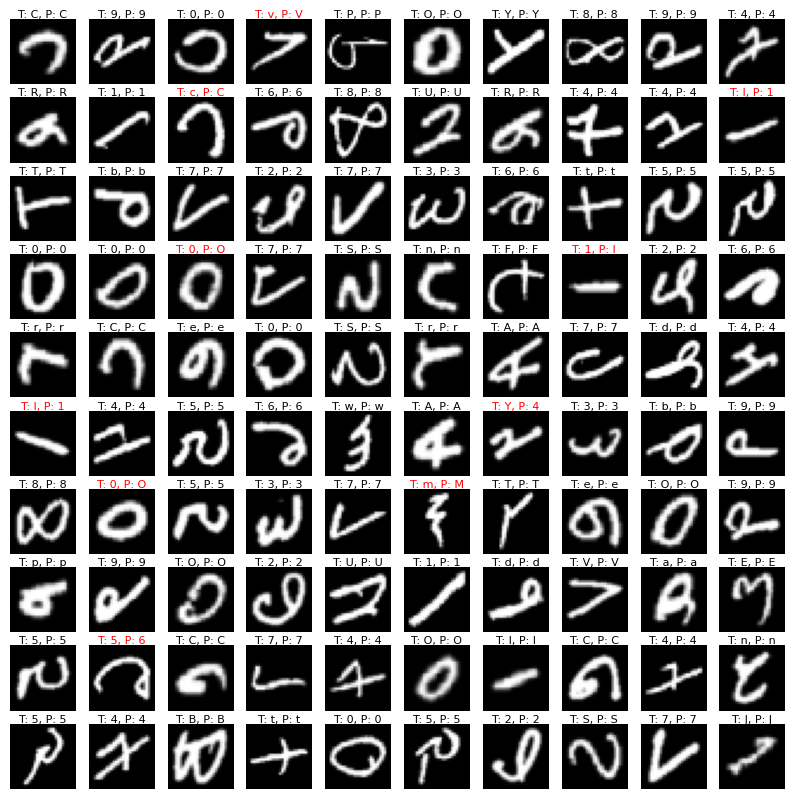

In [10]:
predict_visualise(vggnet, test_loader)

## Generalization ability

In [11]:
transform = transforms.Compose([transforms.Resize(28),
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,)),
                                ])

emnist_train_complete = datasets.EMNIST(root='./EMNIST', split='byclass', train=True, download=True, transform=transform)
emnist_test_complete = datasets.EMNIST(root='./EMNIST', split='byclass', train=False, download=True, transform=transform)

Accuracy on the training set: 87.62%.
Precision on the training set: 86.95%.
Recall on the training set: 87.62%.
F1 Score on the training set: 86.06%.
Accuracy on the test set: 87.22%.
Precision on the test set: 86.51%.
Recall on the test set: 87.22%.
F1 Score on the test set: 85.65%.


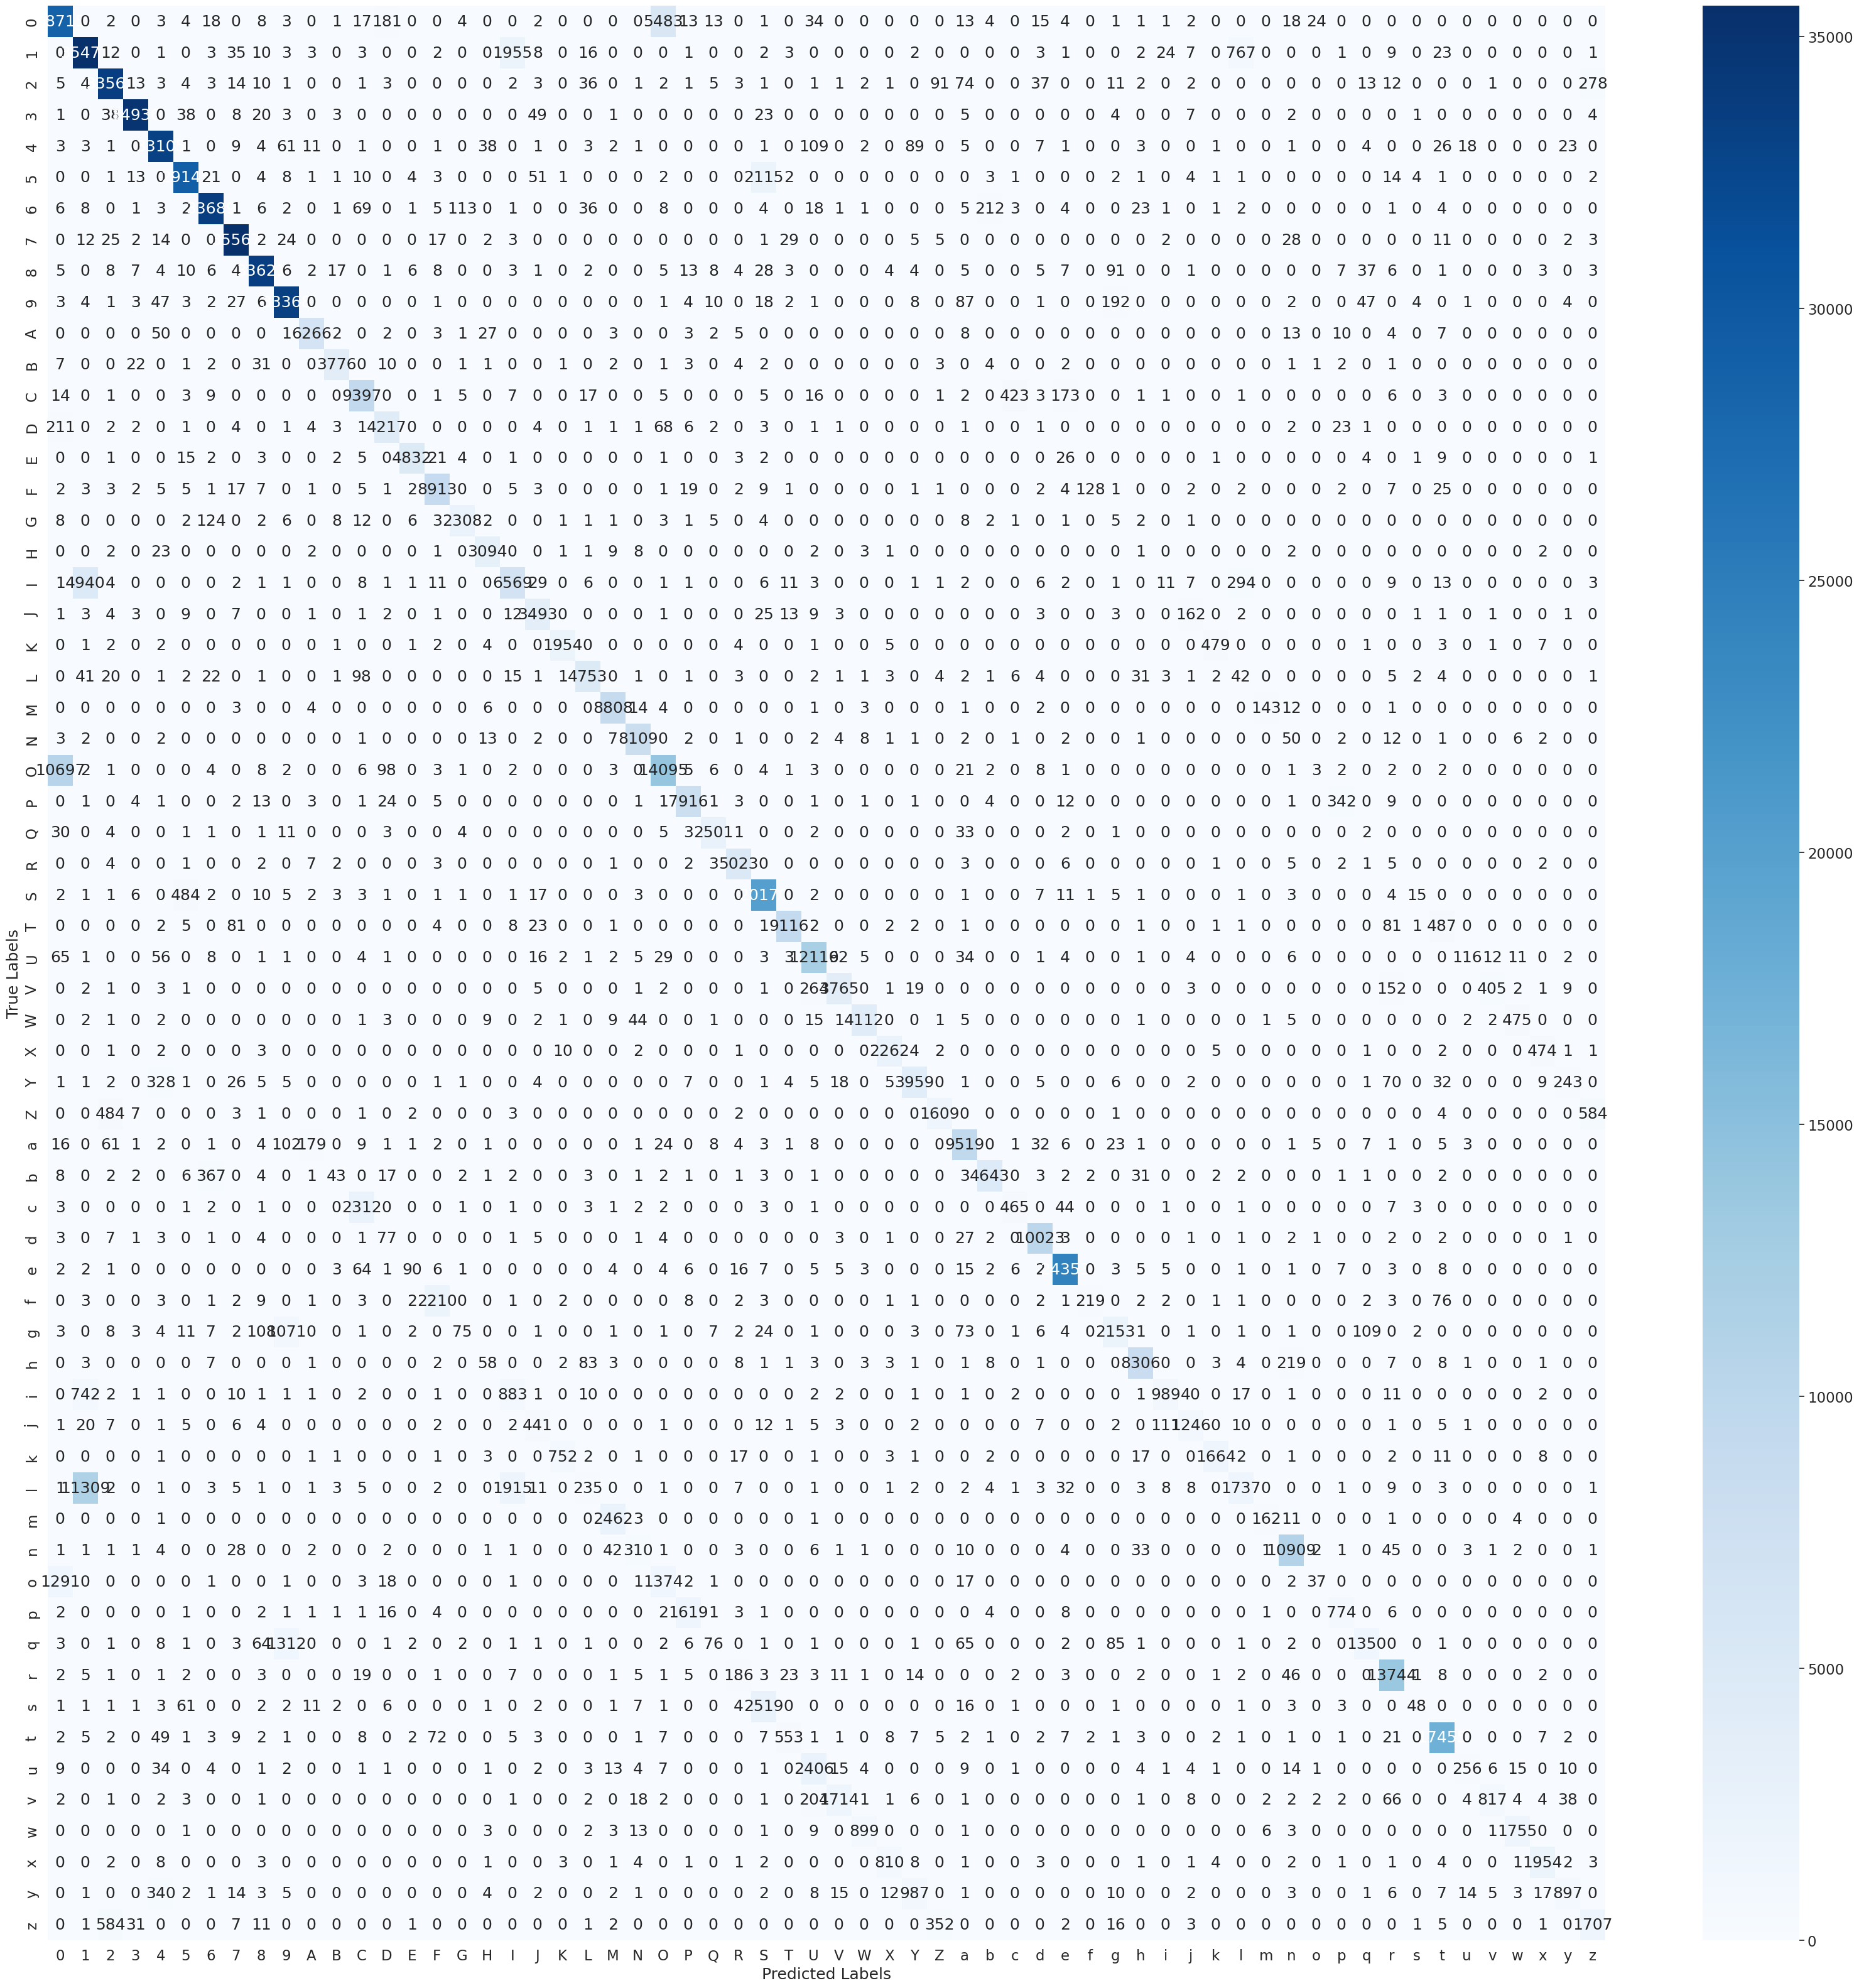

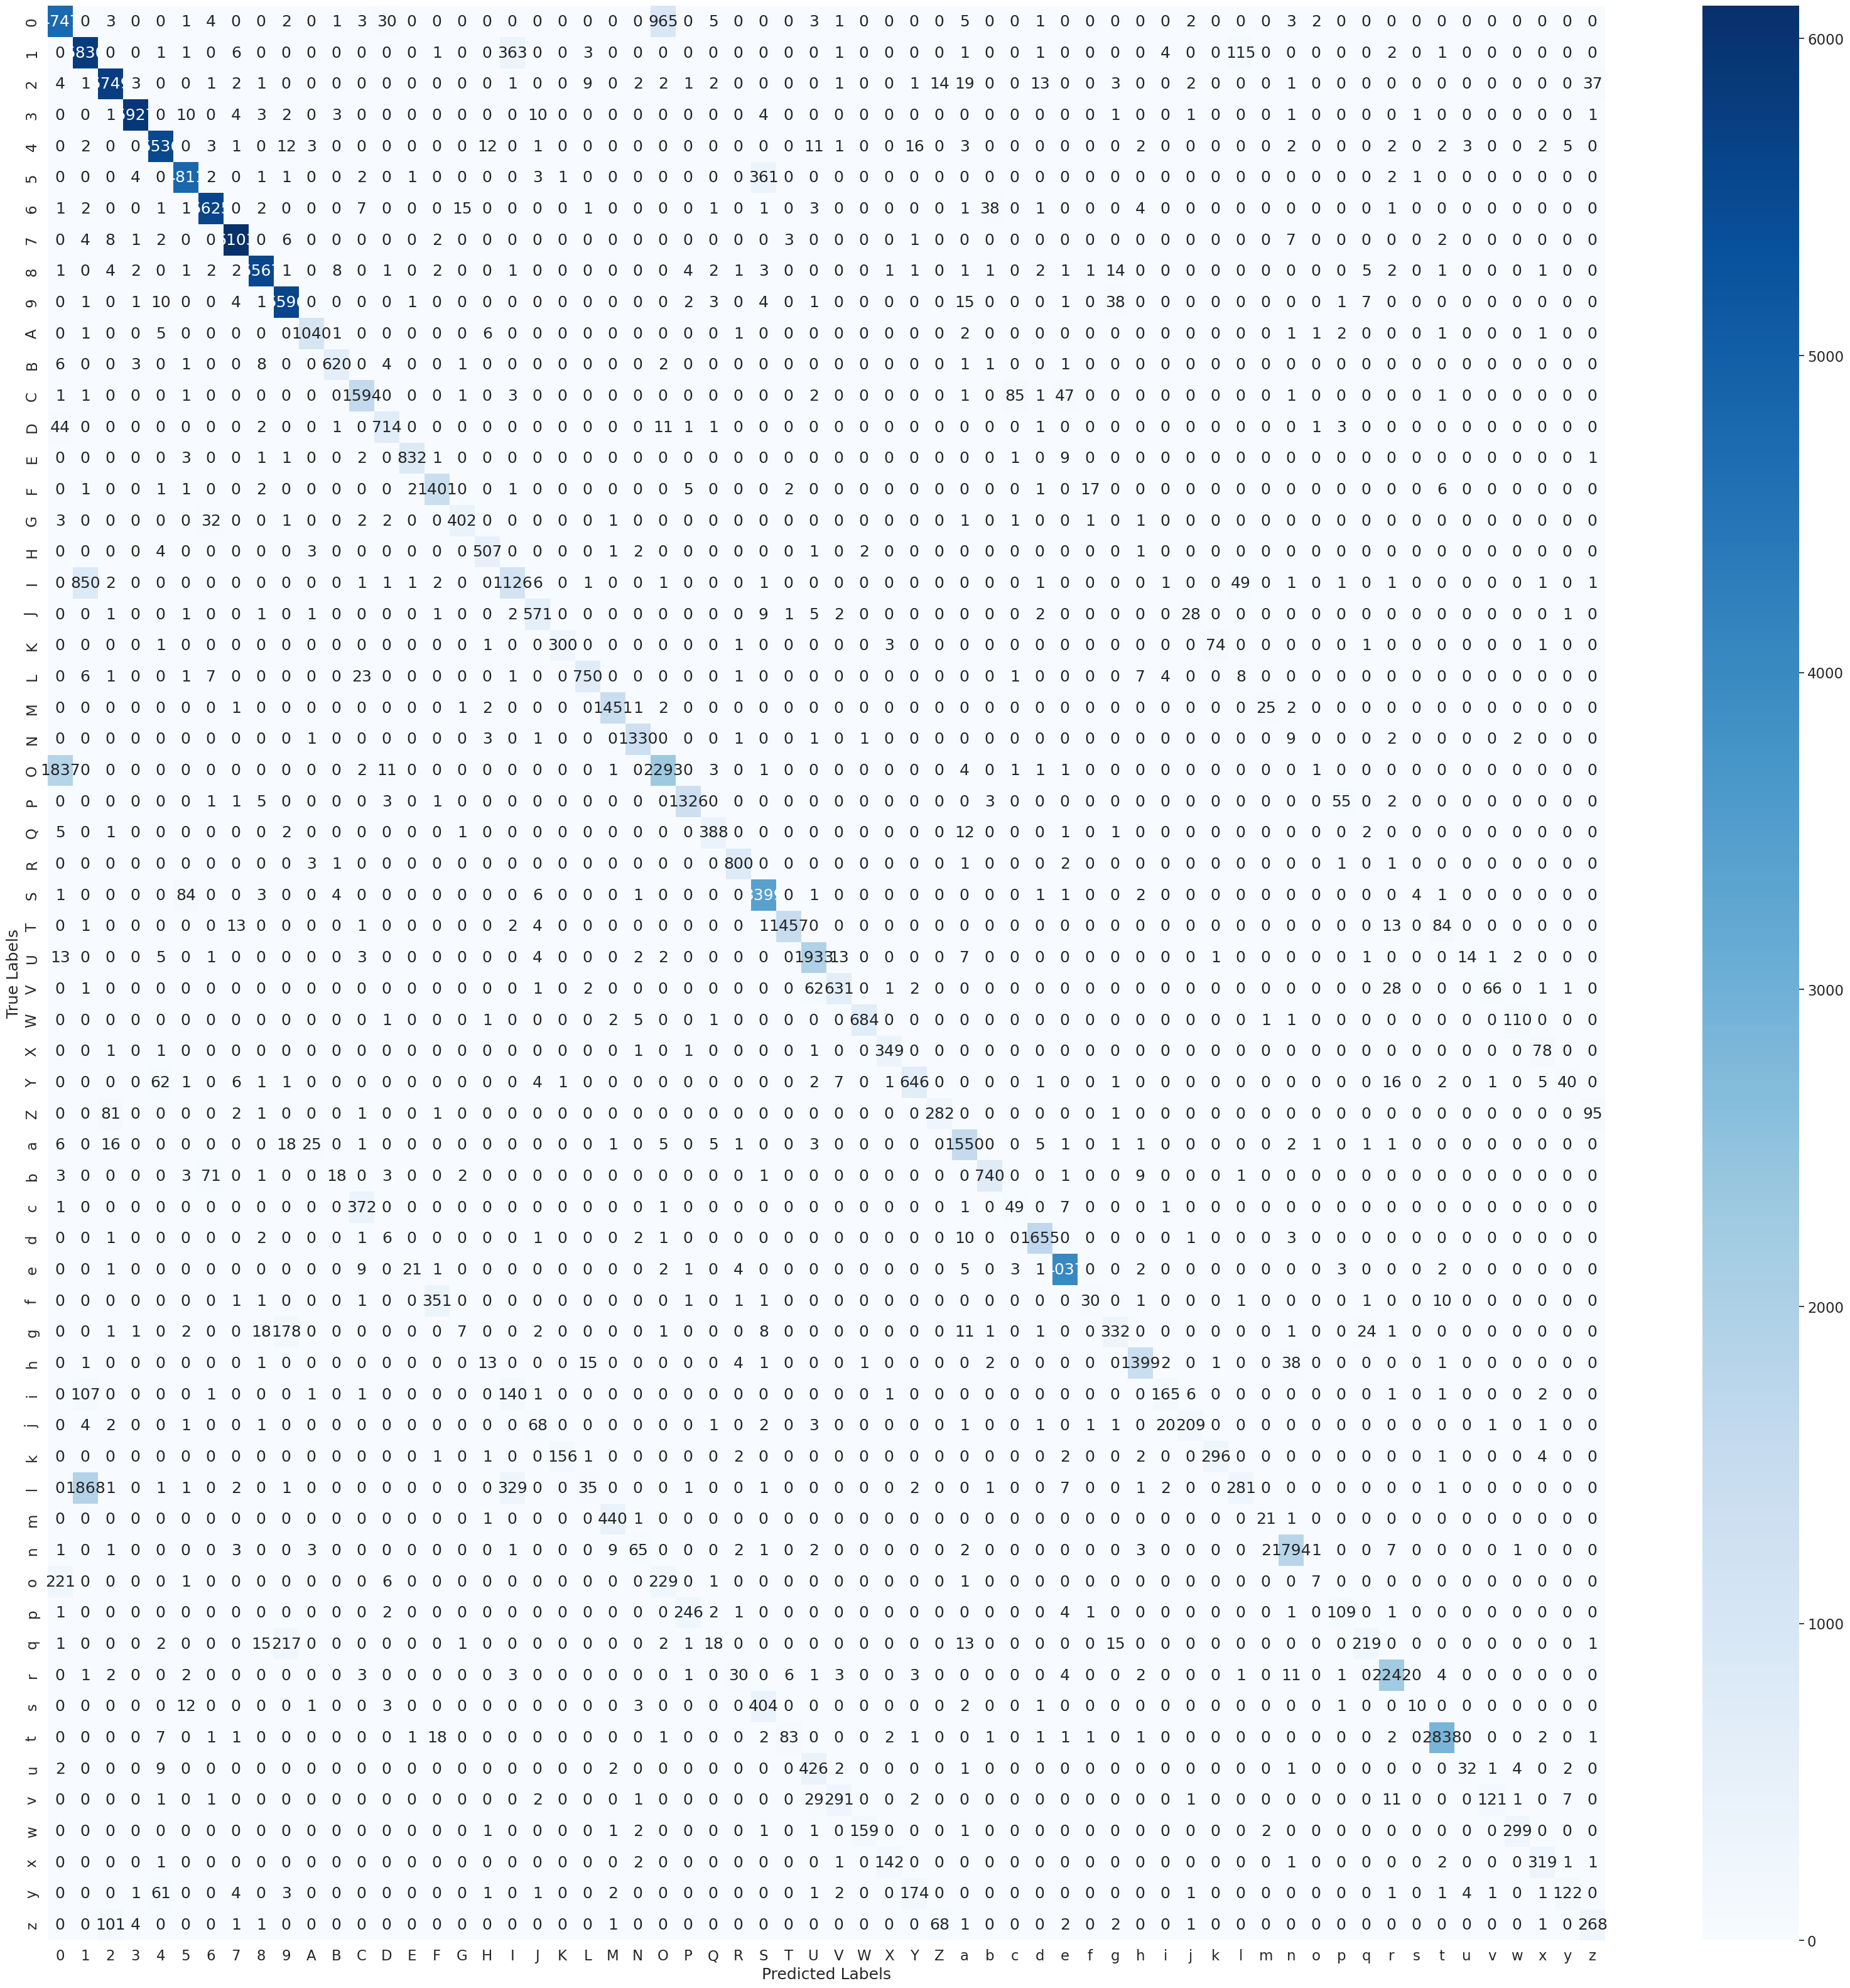

In [12]:
complete_train = DataLoader(emnist_train_complete, batch_size=100, shuffle=False, num_workers=2)
complete_test = DataLoader(emnist_test_complete, batch_size=100, shuffle=False, num_workers=2)
acc_train, precision_train, recall_train, f1_train, cm_train = evaluate(vggnet, complete_train)
acc_test, precision_test, recall_test, f1_test, cm_test = evaluate(vggnet, complete_test)
print(f"Accuracy on the training set: {acc_train*100:.2f}%.")
print(f"Precision on the training set: {precision_train*100:.2f}%.")
print(f"Recall on the training set: {recall_train*100:.2f}%.")
print(f"F1 Score on the training set: {f1_train*100:.2f}%.")
print(f"Accuracy on the test set: {acc_test*100:.2f}%.")
print(f"Precision on the test set: {precision_test*100:.2f}%.")
print(f"Recall on the test set: {recall_test*100:.2f}%.")
print(f"F1 Score on the test set: {f1_test*100:.2f}%.")
confusion_matrix_viz(cm_train)
confusion_matrix_viz(cm_test)

## Transfer learning

In [13]:
def train_(model, train_loader, optimizer, criterion, epochs):
  for ep in tqdm(range(epochs)):
    for step, (x, y) in enumerate(train_loader):
      x = x.float().to(device)
      y = y.to(device)
      optimizer.zero_grad()
      p = model(x)
      loss = criterion(p, y)
      loss.backward()
      optimizer.step()

In [14]:
mean, std = 0.1325, 0.3039
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean, ), (std, ))])
mnist_train = datasets.MNIST(root='./MMNIST', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 255258331.41it/s]

Extracting ./MMNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MMNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 35193403.20it/s]


Extracting ./MMNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MMNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 126379975.45it/s]

Extracting ./MMNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MMNIST/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 7210646.77it/s]


Extracting ./MMNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MMNIST/MNIST/raw



In [15]:
vggnet = VGGNet().to(device)
vggnet.load_state_dict(torch.load("./fine_tuned/vggnet_tuned.pth", map_location=device))
vggnet.classifier[8] = torch.nn.Linear(512, 10)
vggnet.to(device)
for name, param in vggnet.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False
train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=100, shuffle=False)
optimizer = optim.SGD(vggnet.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
epochs = 5
train_(vggnet, train_loader, optimizer, criterion, epochs)

100%|██████████| 5/5 [01:32<00:00, 18.40s/it]


In [16]:
acc_train, precision_train, recall_train, f1_train, cm_train = evaluate(vggnet, train_loader)
acc_test, precision_test, recall_test, f1_test, cm_test = evaluate(vggnet, test_loader)
print(f"Accuracy on the training set: {acc_train*100:.2f}%.")
print(f"Precision on the training set: {precision_train*100:.2f}%.")
print(f"Recall on the training set: {recall_train*100:.2f}%.")
print(f"F1 Score on the training set: {f1_train*100:.2f}%.")
print(f"Accuracy on the test set: {acc_test*100:.2f}%.")
print(f"Precision on the test set: {precision_test*100:.2f}%.")
print(f"Recall on the test set: {recall_test*100:.2f}%.")
print(f"F1 Score on the test set: {f1_test*100:.2f}%.")

Accuracy on the training set: 95.24%.
Precision on the training set: 95.26%.
Recall on the training set: 95.24%.
F1 Score on the training set: 95.24%.
Accuracy on the test set: 95.27%.
Precision on the test set: 95.27%.
Recall on the test set: 95.27%.
F1 Score on the test set: 95.27%.
